
# Wstęp

## Cel ćwiczenia

Celem ćwiczenia jest **wytrenowanie od podstaw sieci typu MLP (Multi-Layer Perceptron)** oraz **analiza wpływu wybranych dobrych praktyk** stosowanych w deep learningu na proces uczenia i jakość uzyskiwanych wyników.
W trakcie zadania będziemy świadomie podejmować decyzje projektowe dotyczące architektury, przygotowania danych oraz procesu treningu.


# Ogólne informacje do zadania

### 1. Zbiór danych

W zadaniu wykorzystany zostanie zbiór **FashionMNIST**, który jest dostępny domyślnie w bibliotece `torchvision`.

Przy pierwszym uruchomieniu notebooka zbiór danych zostanie pobrany na dysk lokalny.
W tym celu należy ustawić flagę `download=True` oraz wskazać odpowiednią ścieżkę w parametrze `root`.

> **Uwaga:**
> W przypadku korzystania z Google Colab zaleca się podłączenie Google Drive, aby uniknąć ponownego pobierania danych przy każdym uruchomieniu środowiska.

Przykładowy kod do pobrania danych (można go modyfikować):

```python
from torchvision import datasets

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
```

Zbiór FashionMNIST służy do **klasyfikacji obrazów należących do 10 różnych klas odpowiadającym elementom garderoby** (np. koszulka, płaszcz, but itp).
Nie jest to zbiór przesadnie trudny, natomiast jego plusem jest szybki czas przetwarzania.

### UWAGA
Jeśli ktoś chciałby mieć większe wyzwanie to polecam przeprowadzić rozwiązania na zbiorze [CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvisiondatasets.CIFAR10.html), który nie jest już tak trywialnym zbiorem (dalej ma obrazki i 10 klas, natomiast klasyfikacja jest trudniejsza oraz czas przetwarzania, będzie większy). Jest on również dostępny w `torchvision.datasets` przez co pobiera go się go w analogiczny sposób co MNIST





### 2. Trenowanie sieci MLP

Celem zadania jest wykorzystanie zdobytej wiedzy z zakresu implementacji modeli w **PyTorch** lub **PyTorch Lightning** do wytrenowania sieci składającej się z kilku warstw liniowych (stąd nazwa **Multi-Layer Perceptron**).

Model będzie używany do klasyfikacji obrazów, mimo że:

* dla danych obrazowych **znacznie lepiej sprawdzają się sieci konwolucyjne (CNN)**,
* MLP nie wykorzystuje informacji o strukturze przestrzennej obrazu.

Świadomie ograniczamy się tutaj do MLP, ponieważ:

* pozwala to skupić się na **uniwersalnych dobrych praktykach**, które będą opisane poniżej:
* ułatwia zrozumienie **dlaczego i w jaki sposób CNN przewyższają MLP** w zadaniach wizji komputerowej.

Dopiero po zaobserwowaniu ograniczeń klasycznej sieci MLP możliwe jest pełne docenienie zalet architektur konwolucyjnych, które zostaną omówione w kolejnych zadaniach.

W ramach teorii potrzebnej do zrozumienia na czym polega uczenie sieci MLP, bardzo mocno polecam pierwsze 4 rozdziały z playlist [Neural Networks 3Blue 1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi), która w świetny sposób tłumaczy to zagadnienie. Dodatkowo jeśli ktoś nie czuje się do końca dobrze z algorytmem propagacji wstecznej, to również polecam obejrzeć.




### 3. Wykorzystanie dobrych praktyk w trakcie uczenia modelu

W poprzedniej liście zadań trenowaliście **pojedynczy perceptron**, który można uznać za bardzo prostą sieć neuronową.
Proces uczenia polegał głównie na doborze podstawowych hiperparametrów, takich jak:

* liczba epok,
* współczynnik uczenia (*learning rate*).

Dodatkowo wykorzystywany był **zbiór walidacyjny**, który pozwalał obserwować wartość funkcji straty na danych niewidzianych przez model w trakcie uczenia.
Jest to kluczowy element oceny zdolności modelu do **generalizacji**, czyli sprawdzenia, czy model nie uczy się na pamięć danych treningowych (*overfitting*).

W praktycznych zastosowaniach deep learningu stosuje się jednak **szereg dodatkowych technik**, które:

* stabilizują proces uczenia,
* poprawiają generalizację,
* ułatwiają analizę i debugowanie modeli.

W ramach tego zadania będziecie musieli **zrozumieć wszystkie poniższe techniki** oraz przebadać wpływ części z nich na proces uczenia.

---

#### 3.1 Monitorowanie `val_loss` i zapisywanie najlepszego modelu

Podczas treningu wartość straty na zbiorze walidacyjnym (`val_loss`) **nie zawsze maleje monotonicznie**.
Często model osiąga najlepsze wyniki na danych walidacyjnych w pewnej epoce, po czym zaczyna się przeuczać.

Dlatego:

* w trakcie uczenia monitorujemy `val_loss`,
* zapisujemy parametry modelu z epoki, w której `val_loss` było **najniższe**,
* po zakończeniu treningu **ładujemy najlepszy zapisany model**, a nie ten z ostatniej epoki.

**Dlaczego to robimy?**

* minimalizujemy ryzyko overfittingu,
* wykorzystujemy model o najlepszej zdolności generalizacji,
* wynik końcowy nie zależy od arbitralnie dobranej liczby epok.

Technika ta jest często realizowana poprzez tzw. *checkpointing*.

---

#### 3.2 Early stopping

**Early stopping** to mechanizm, który **automatycznie przerywa trening**, jeśli jakość modelu na zbiorze walidacyjnym przestaje się poprawiać.

Działanie:

* obserwujemy `val_loss`,
* jeśli przez określoną liczbę epok (*patience*) nie nastąpi poprawa,
* trening zostaje zakończony.

**Dlaczego to robimy?**

* zapobiegamy przeuczeniu modelu,
* skracamy czas treningu,
* oszczędzamy zasoby obliczeniowe.

Early stopping jest szczególnie skuteczny w połączeniu z **zapisywaniem najlepszego modelu**, ponieważ zapewnia, że końcowy model pochodzi z najlepszego momentu treningu.

**Materiały**
- [Early stopping](https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf)

---

#### 3.3 Logowanie metryk i funkcji straty

W trakcie treningu należy logować:

* wartość funkcji straty (`loss`),
* metryki jakości (np. accuracy),
* zarówno dla zbioru treningowego, jak i walidacyjnego.

Logowanie może odbywać się:

* do **TensorBoarda**,
* lub w formie danych umożliwiających późniejsze narysowanie wykresów.

**Dlaczego to robimy?**

* umożliwia to wizualną analizę procesu uczenia,
* pozwala szybko wykryć problemy (np. overfitting, zbyt duży learning rate, niestabilne uczenie),
* ułatwia porównywanie różnych eksperymentów i konfiguracji modelu.

W praktyce logowanie jest jednym z podstawowych narzędzi pracy z modelami deep learningowymi.

---

#### 3.4 Regularizacja (L1, L2, Dropout)

Regularizacja ma na celu **ograniczenie nadmiernej złożoności modelu**, co poprawia jego zdolność generalizacji.

* **L1 (Lasso):**

  * dodaje do funkcji straty sumę wartości bezwzględnych wag:

$$
\begin{aligned}
 \lambda \sum_{i} |w_i|
\end{aligned}
$$


  * sprzyja rzadkim rozwiązaniom (wiele wag przyjmuje wartości bliskie zeru).

* **L2 (Ridge / weight decay):**

  * dodaje do funkcji straty sumę kwadratów wag:
$$
\begin{aligned}
    \lambda \sum_{i} w_i^2
\end{aligned}
$$

  * zapobiega nadmiernemu wzrostowi wag,

  * jest najczęściej stosowaną formą regularizacji w deep learningu.

* **Dropout:**

  * w trakcie treningu losowo „wyłącza” część neuronów,
  * zmusza sieć do uczenia się bardziej odpornych reprezentacji,
  * działa jak uśrednianie wielu modeli.

**Dlaczego to robimy?**

* zmniejszamy overfitting,
* poprawiamy stabilność uczenia,
* model lepiej generalizuje na nowe dane.

> **Uwaga:** regularizacja to hiperparametr – jej siłę należy dobrać eksperymentalnie.
> Zbyt silna regularizacja może prowadzić do *underfittingu*.

**Materiały pomocniczne**

* [regularyzacja L1 i L2](https://medium.com/@alejandro.itoaramendia/l1-and-l2-regularization-part-1-a-complete-guide-51cf45bb4ade)
* [dropout](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575)

---

#### 3.5 Harmonogram uczenia – Cosine Learning Rate Scheduling

Zamiast używać stałego learning rate, często stosuje się **harmonogram jego zmiany w czasie**.

**LR scheduling (np. Cosine Scheduling):**

* learning rate zmniejsza się zgodnie z krzywą cosinusa,
* na początku uczenie jest agresywne,
* pod koniec staje się bardzo delikatne.

Intuicyjnie:

* duży learning rate pomaga szybko znaleźć dobry obszar rozwiązań,
* mały learning rate pozwala dokładnie „dostroić” wagi.

**Dlaczego to robimy?**

* poprawiamy stabilność uczenia,
* często osiągamy lepsze minima funkcji straty,
* zmniejszamy potrzebę ręcznego doboru learning rate.

> W praktyce harmonogram uczenia często ma **większy wpływ na wynik końcowy** niż niewielkie zmiany architektury.

**Materiały**

* [cosine scheduling](https://medium.com/@utkrisht14/cosine-learning-rate-schedulers-in-pytorch-486d8717d541)

---

#### 3.6 Batch Normalization

**Batch Normalization (BatchNorm)** to technika polegająca na **normalizacji aktywacji w warstwach sieci neuronowej** w trakcie treningu.

Dla każdej cechy w mini-batchu:

* odejmowana jest średnia,
* dzielone jest przez odchylenie standardowe,
* a następnie stosowane są uczone parametry skali i przesunięcia.

Intuicyjnie:

* dane „wewnątrz sieci” mają stabilniejszy rozkład,
* kolejne warstwy dostają lepiej uwarunkowane wejście.

**Dlaczego to robimy?**

* stabilizujemy i przyspieszamy proces uczenia,
* umożliwiamy stosowanie większego learning rate,
* zmniejszamy wrażliwość modelu na inicjalizację wag,
* często poprawiamy generalizację (BatchNorm działa częściowo jak regularizacja).

**Ważne uwagi praktyczne:**

* BatchNorm **zachowuje się inaczej w trakcie treningu i inferencji**
  (używa statystyk batcha vs. statystyk zebranych podczas treningu).
* Nie zawsze jest konieczna- w małych sieciach lub przy bardzo małych batchach może **nie przynieść korzyści**.
* BatchNorm **nie jest zamiennikiem regularizacji** (np. Dropoutu), choć czasem może zmniejszyć jej potrzebę.

**Matariały**
- [Batch Normalization](https://medium.com/@piyushkashyap045/understanding-batch-normalization-in-deep-learning-a-beginners-guide-40917c5bebc8)

**UWAGA**
W praktyce nie dodajemy Batch Normalization „w ciemno” do każdej warstwy. Przy części problemów może ona okazać się bardzo pomocna i są pewne architektury które bez niej sobie nie są w stanie poradzić, ale dla prostych problemów jej wpływ może nie być wcale duży. Warto natomiast w każdym przypadku być świadomym, że coś takiego istnieje, ponieważ jest to techina bardzo szeroko stosowana.


# 4. Elementy architektury i treningu, o których należy pamiętać

Poza dobrymi praktykami związanymi z procesem uczenia (takimi jak early stopping, regularizacja czy harmonogram learning rate), istnieją również **podstawowe decyzje projektowe**, które są **ściśle związane z architekturą sieci oraz sposobem jej trenowania**.

Elementy te często mają **istotny wpływ na zbieżność uczenia, stabilność gradientów oraz końcową jakość modelu**, dlatego warto mieć ich istnienie na uwadze — nawet jeśli w tym zadaniu nie będą one głównym obiektem badań.

W szczególności należą do nich:

---

#### 4.1 Funkcje aktywacji

Funkcja aktywacji określa, w jaki sposób sygnał wyjściowy neuronu jest przekształcany i przekazywany do kolejnych warstw.
W praktyce deep learningu najczęściej spotyka się następujące, **bazowe funkcje aktywacji**:

* **Sigmoid**
  Historycznie bardzo popularna, obecnie rzadziej stosowana w warstwach ukrytych ze względu na problem zanikającego gradientu.

* **Tanh**
  Podobna do sigmoidy, ale o wyjściu symetrycznym względem zera; również może prowadzić do problemów z gradientami w głębokich sieciach.

* **ReLU (Rectified Linear Unit)**
  Najczęściej stosowana funkcja aktywacji w nowoczesnych sieciach neuronowych; prosta i skuteczna, sprzyja stabilnemu uczeniu.

Wybór funkcji aktywacji wpływa na dynamikę uczenia i może znacząco zmienić zachowanie modelu, nawet przy tej samej architekturze.


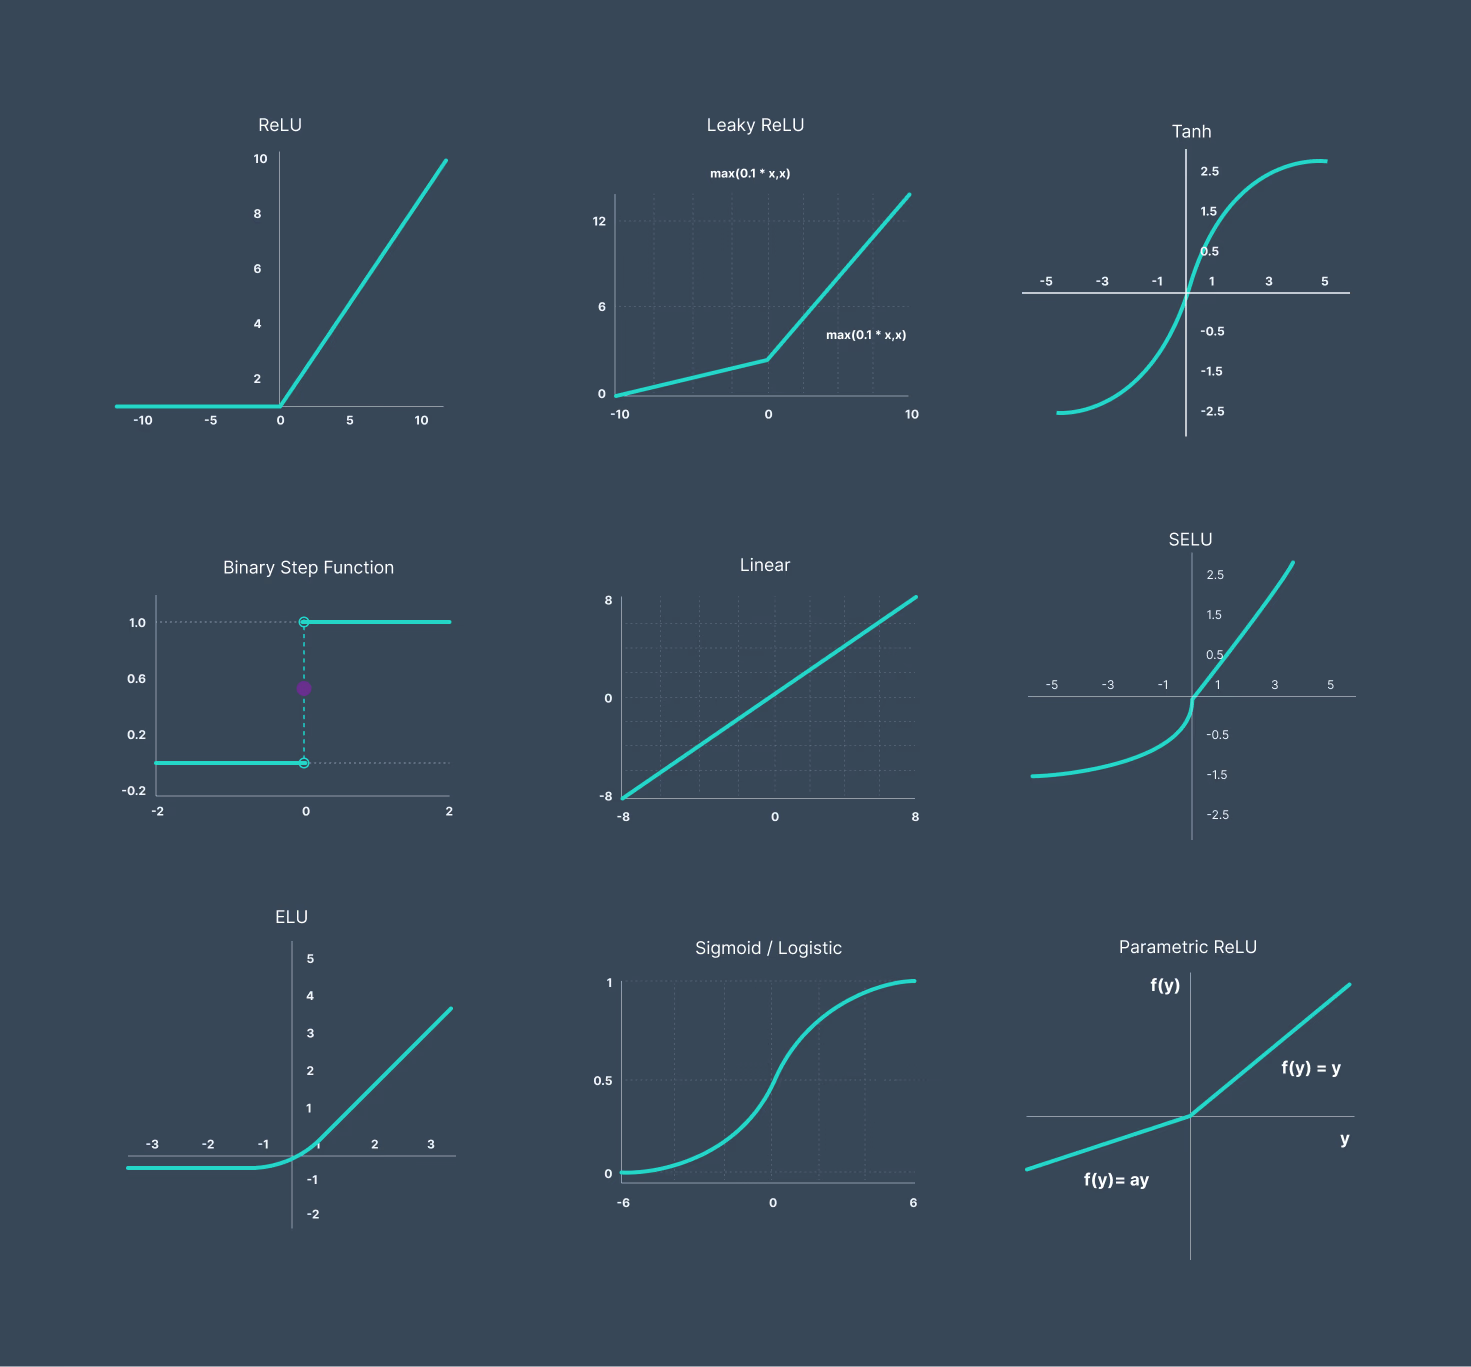


---

#### 4.2 Optymalizatory

Optymalizator określa, **w jaki sposób aktualizowane są wagi modelu** na podstawie obliczonych gradientów funkcji straty.

Do najczęściej stosowanych optymalizatorów należą:

* **SGD (Stochastic Gradient Descent)**
  Klasyczna metoda oparta bezpośrednio na gradiencie; często wymaga starannego doboru learning rate i dodatkowych technik (np. momentum).

* **[Adam](https://www.geeksforgeeks.org/deep-learning/adam-optimizer/)**
  Adaptacyjny optymalizator, który automatycznie dostosowuje learning rate dla poszczególnych parametrów; bardzo popularny ze względu na dobrą stabilność i szybkie zbieganie.


Wybór optymalizatora ma wpływ na szybkość uczenia, stabilność treningu oraz jakość znalezionego minimum funkcji straty. W praktyce wybór Adama jest zawsze dobrym wyborem i ciężko znaleźć kod który wybiera inny optymalizator. Kluczowe jednak jest wiedzieć, że tak jak większość optymalizatorów, mocno bazuje na SGD, dlatego warto być świadomym również jak działa ten klasyczny algorytm.
Z mniej znanych metod o których warto wspomnieć są [AdaGrad](https://www.geeksforgeeks.org/machine-learning/intuition-behind-adagrad-optimizer/), [RMSProp](https://medium.com/@piyushkashyap045/understanding-rmsprop-a-simple-guide-to-one-of-deep-learnings-powerful-optimizers-403baeed9922)





# KROKI DO WYKONANIA ZADANIA

W ramach zadania jesteście proszeni o wykonanie następujących kroków:

### 1. Przygotowanie danych

* Załadujcie zbiór danych i **zwizualizujcie kilka przykładowych obserwacji** (np. rozmiar obrazów, liczba kanałów, czy są kolorowe czy w skali szarości).
* Utwórzcie **DataLoadery** dla zbiorów *train*, *validation* oraz *test*, które będą zwracały dane w formacie odpowiednim dla modelu.
* Na potrzeby tego zadania **augmentacja danych nie jest wymagana**.

---

### 2. Definicja modelu

* Przygotujcie klasę `ParameterizedMLP`, która będzie definiowała architekturę sieci neuronowej.
* Klasa powinna być **sparametryzowana**, tak aby możliwe było sterowanie architekturą modelu poprzez przekazywane argumenty, w szczególności:

  * liczba warstw ukrytych oraz liczba neuronów w każdej z nich,
  * użycie Batch Normalization (wystarczy flaga typu `bool`).

---

### 3. Kod treningowy

* Napiszcie kod umożliwiający trening modelu, **obowiązkowo korzystając z PyTorcha lub frameworka PyTorch Lightning**.
* Kod powinien umożliwiać:

  * logowanie wartości funkcji straty oraz metryk jakości dla zbiorów *train* i *validation* w każdej epoce,
  * ustawienie parametru `patience`, kontrolującego działanie mechanizmu *early stopping*,
  * ewaluację modelu na zbiorze testowym po zakończeniu treningu,
  * zapisanie **najlepszego modelu** (na podstawie wyników walidacyjnych).
* Proces treningu musi być **zdeterminowany (seedowany)**, tak aby możliwe było rzetelne porównywanie wyników pomiędzy eksperymentami.

---

### 4. Eksperymenty

Na przygotowanym kodzie należy przeprowadzić **kilka eksperymentów**, których celem jest zbadanie wpływu wybranych technik na proces uczenia modelu.

W szczególności powinny się pojawić następujące eksperymenty:

* **Early stopping**
  Porównanie przebiegu krzywych uczenia w przypadku:

  * treningu bez early stoppingu,
  * treningu z włączonym early stoppingiem.

* **Architektura sieci**
  Eksperymenty z różnymi architekturami sieci. Dowolność jak chcecie do tego podejść. Ja polecam dla dodania ciekawości zadania sprawdzić:
  * bardzo małą architetę
  * dużą architekturę
  * i jakąś pomiędzy którą uznamy za optymalną

* **Regularizacja**
  Porównanie uczenia:

  * z regularizacją L1 lub L2 vs. bez regularizacji,
  * z Dropoutem vs. bez Dropoutu.

* **Scheduling learning rate**
  Eksperyment pokazujący wpływ harmonogramu zmiany learning rate.
  W tym przypadku warto również **logować wartość learning rate w kolejnych epokach**.

* **Batch Normalization**
  Porównanie modelu:

  * z Batch Normalization,
  * bez Batch Normalization.

* **Optymalizator**
  Porównanie algorytmu optyalizującego wagi:
  * Adam (jako najczęściej stosowany w praktyce)
  * SGD (klasyczna metoda)

---

## UWAGI

* Nie jest wymagane przeprowadzanie rozbudowanego *grid searcha* ani badanie wszystkich możliwych kombinacji technik.
  Wystarczy podejście inkrementalne:

  * trenujecie **bazowy model** (prosta architektura, bez regularizacji, bez schedulingu learning rate, bez early stoppingu, itd),
  * następnie w kolejnych eksperymentach **zmieniacie tylko jeden czynnik naraz** (np. dodajecie early stopping, zwiększacie liczbę warstw, włączacie scheduler itp.) i obserwujecie jego wpływ na wyniki.

* Z tego powodu **wszystkie eksperymenty powinny być wykonywane na tym samym seedzie oraz tym samym podziale danych** (ten sam split train/val/test), aby porównania były miarodajne.

* Warto zadbać o to, aby kod był **czytelny, modularny i dobrze zorganizowany**.
  W kolejnych zadaniach będziecie pracować z modelami konwolucyjnymi — dobrze napisany kod treningowy będzie można w dużej mierze ponownie wykorzystać.
* W tym zadaniu nie jest wymagane systematyczne porównywanie wszystkich funkcji aktywacji (chodź nie jest zakazane), należy natomiast wybrać jedną i uwzględnić ją w implementacji modelu.


In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import copy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Ustawienie seedu do wszystkich generatorów.

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 8
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Pobranie datasetów treningowych i walidacyjnych

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_full = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(train_full)

100%|██████████| 26.4M/26.4M [00:00<00:00, 107MB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.63MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 63.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 4.95MB/s]


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


Analiza pobranych danych

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
-----------
types:
<class 'torch.Tensor'>
<class 'int'>
-----------
image data:
torch.Size([1, 28, 28])
tensor(0.) tensor(1.)
-----------
labels:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


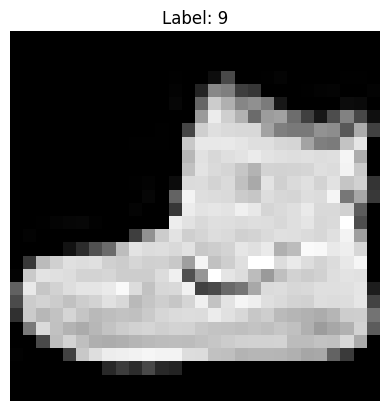

In [ ]:
image, label = train_full[0]
print(train_full)

print("-----------")
print("types:")
print(type(image))
print(type(label))

print("-----------")
print("image data:")
print(image.shape)
print(image.min(), image.max())

print("-----------")
print("labels:")
print(train_full.classes)

plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()



Wydzielenie zbioru walidacyjnego i data loadery.

In [ ]:

train_size = 50000
val_size = 10000

trainset, valset = random_split(
    train_full,
    [train_size, val_size]
)


batch_size = 256

train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator().manual_seed(seed)
)

val_loader = DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

images, labels = next(iter(train_loader))
print("Images batch shape:", images.shape)  # [64, 1, 28, 28]
print("Labels batch shape:", labels.shape)  # [64]


Images batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


Stworzenie modelu

In [ ]:
class ParameterizedMLP(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_sizes,
        output_size,
        use_batchnorm=False,
        dropout_p=0.0
    ):
        super().__init__()

        layers = []
        in_size = input_size

        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_size, h_size))

            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_size))

            layers.append(nn.ReLU())

            if dropout_p > 0:
                layers.append(nn.Dropout(p=dropout_p))

            in_size = h_size

        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

input_size = 28*28
hidden_sizes = [128, 64]
output_size = 10
use_batchnorm = True
dropout_p = 0.3

model = ParameterizedMLP(input_size, hidden_sizes, output_size, use_batchnorm, dropout_p)
print(model)

ParameterizedMLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)


Funkcja do trenowania

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader=None,
    epochs=20,
    lr=0.002,
    patience=5,
    optim_class=optim.Adam,
    device="cuda" if torch.cuda.is_available() else "cpu",
    l1_lambda=0.0,
    l2_lambda=0.0,
    use_cosine_scheduler=False
):

    model.to(device)

    criterion = nn.CrossEntropyLoss()

    # (L2)
    optimizer = optim_class(
        model.parameters(),
        lr=lr,
        weight_decay=l2_lambda if l2_lambda > 0 else 0.0
    )

    scheduler = None
    if use_cosine_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs,
            eta_min=1e-6
        )


    best_val_loss = float("inf")
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
        "lr": []
    }

    for epoch in range(epochs):
        # ===== TRAIN =====
        model.train()
        train_loss = 0.0
        all_preds, all_targets = [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)

            loss = criterion(outputs, y)

            # (L1)
            if l1_lambda > 0:
                l1_penalty = 0.0
                for p in model.parameters():
                    l1_penalty += torch.sum(torch.abs(p))
                loss = loss + l1_lambda * l1_penalty

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(all_targets, all_preds)
        train_precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
        train_recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
        train_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_precision"].append(train_precision)
        history["train_recall"].append(train_recall)
        history["train_f1"].append(train_f1)

        # ===== VALIDATION =====
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            all_preds, all_targets = [], []

            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    loss = criterion(outputs, y)

                    val_loss += loss.item() * x.size(0)
                    _, preds = torch.max(outputs, 1)

                    all_preds.append(preds.cpu())
                    all_targets.append(y.cpu())

            all_preds = torch.cat(all_preds).numpy()
            all_targets = torch.cat(all_targets).numpy()

            val_loss /= len(val_loader.dataset)
            val_acc = accuracy_score(all_targets, all_preds)
            val_precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
            val_recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
            val_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["val_precision"].append(val_precision)
            history["val_recall"].append(val_recall)
            history["val_f1"].append(val_f1)

        current_lr = optimizer.param_groups[0]["lr"]
        history["lr"].append(current_lr)

        if val_loader is not None:
            print(
                f"Epoch [{epoch+1}/{epochs}] | "
                f"LR:{current_lr:.6f} | "
                f"Train L:{train_loss:.4f} A:{train_acc:.4f} "
                f"F1:{train_f1:.4f} | "
                f"Val L:{val_loss:.4f} A:{val_acc:.4f} "
                f"F1:{val_f1:.4f}"
            )

            if patience > 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print("Early stopping")
                        model.load_state_dict(best_model_wts)
                        return model, history
        if scheduler is not None:
          scheduler.step()

    model.load_state_dict(best_model_wts)
    return model, history

#=========================================

#train_model(model=model,train_loader = train_loader, val_loader = val_loader, epochs=50, lr=0.002, l1_lambda = 0.00001, l2_lambda=0.0001)

Funkcja do ewaluacji modelu na zbiorze testowym po trenowaniu.

In [ ]:
def evaluate_model(
    model,
    test_loader,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            test_loss += loss.item() * x.size(0)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(all_targets, all_preds)
    test_precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    test_recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    test_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

    print("\n===== TEST RESULTS =====")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")
    print(f"Test F1-score:  {test_f1:.4f}")

    return {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1": test_f1
    }


#evaluate_model(model, test_loader)

In [ ]:
def plot_history(history, title):
    epochs = range(1, len(history["lr"]) + 1)

    plt.figure(figsize=(20, 4))

    # ===== LR =====
    plt.subplot(1, 4, 1)
    plt.plot(epochs, history["lr"])
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")

    # ===== LOSS =====
    plt.subplot(1, 4, 2)
    plt.plot(epochs, history["train_loss"], label="Train")
    if len(history["val_loss"]) > 0:
        plt.plot(epochs, history["val_loss"], label="Val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    # ===== ACCURACY =====
    plt.subplot(1, 4, 3)
    plt.plot(epochs, history["train_acc"], label="Train")
    if len(history["val_acc"]) > 0:
        plt.plot(epochs, history["val_acc"], label="Val")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

    # ===== F1 =====
    plt.subplot(1, 4, 4)
    plt.plot(epochs, history["train_f1"], label="Train")
    if len(history["val_f1"]) > 0:
        plt.plot(epochs, history["val_f1"], label="Val")
    plt.title("F1 Score")
    plt.xlabel("Epoch")
    plt.legend()

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Eksperymenty

1. Różne wymiary
Epoch [1/20] | LR:0.005000 | Train L:0.8571 A:0.6955 F1:0.6895 | Val L:0.5616 A:0.8052 F1:0.8013
Epoch [2/20] | LR:0.005000 | Train L:0.5323 A:0.8171 F1:0.8145 | Val L:0.4885 A:0.8357 F1:0.8326
Epoch [3/20] | LR:0.005000 | Train L:0.4883 A:0.8316 F1:0.8306 | Val L:0.4608 A:0.8413 F1:0.8358
Epoch [4/20] | LR:0.005000 | Train L:0.4722 A:0.8374 F1:0.8367 | Val L:0.4433 A:0.8469 F1:0.8466
Epoch [5/20] | LR:0.005000 | Train L:0.4541 A:0.8429 F1:0.8423 | Val L:0.4491 A:0.8448 F1:0.8419
Epoch [6/20] | LR:0.005000 | Train L:0.4454 A:0.8450 F1:0.8444 | Val L:0.4312 A:0.8521 F1:0.8502
Epoch [7/20] | LR:0.005000 | Train L:0.4392 A:0.8480 F1:0.8475 | Val L:0.4224 A:0.8533 F1:0.8520
Epoch [8/20] | LR:0.005000 | Train L:0.4331 A:0.8515 F1:0.8509 | Val L:0.4214 A:0.8546 F1:0.8517
Epoch [9/20] | LR:0.005000 | Train L:0.4297 A:0.8526 F1:0.8521 | Val L:0.4210 A:0.8519 F1:0.8505
Epoch [10/20] | LR:0.005000 | Train L:0.4264 A:0.8521 F1:0.8515 | Val L:0.4461 A:0.8447 F1:0.8410
Epoch [11/20

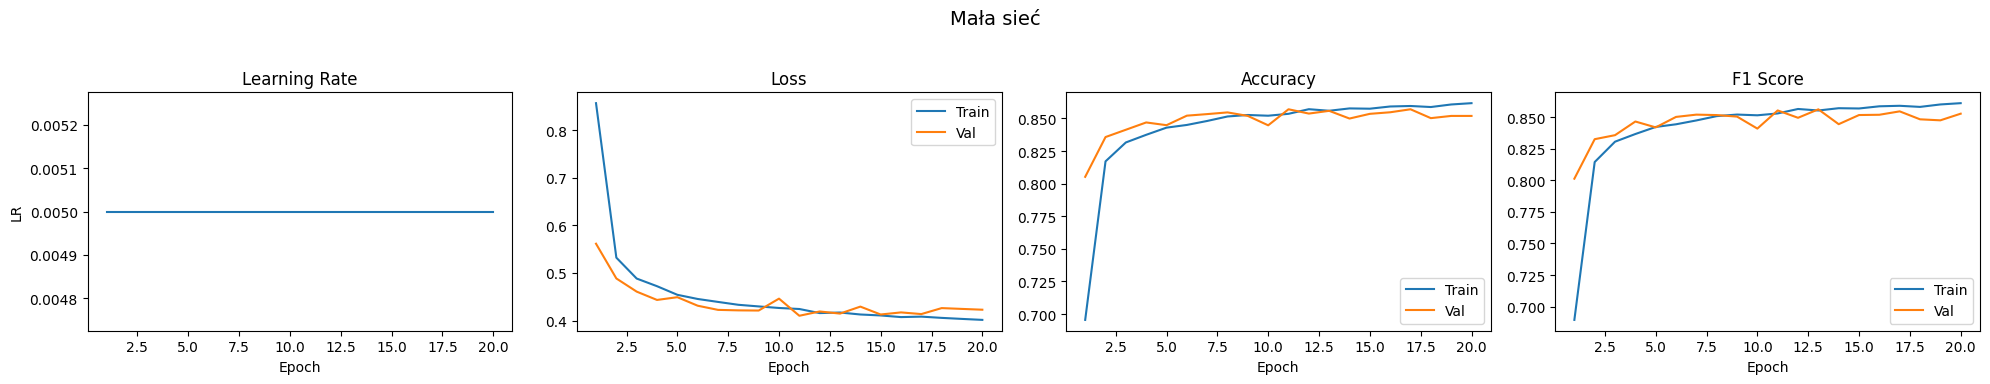

Epoch [1/20] | LR:0.005000 | Train L:0.8960 A:0.6832 F1:0.6814 | Val L:0.5356 A:0.8161 F1:0.8161
Epoch [2/20] | LR:0.005000 | Train L:0.5086 A:0.8243 F1:0.8236 | Val L:0.4658 A:0.8399 F1:0.8357
Epoch [3/20] | LR:0.005000 | Train L:0.4595 A:0.8403 F1:0.8401 | Val L:0.4416 A:0.8476 F1:0.8452
Epoch [4/20] | LR:0.005000 | Train L:0.4322 A:0.8489 F1:0.8487 | Val L:0.4108 A:0.8558 F1:0.8534
Epoch [5/20] | LR:0.005000 | Train L:0.4180 A:0.8529 F1:0.8527 | Val L:0.4119 A:0.8549 F1:0.8530
Epoch [6/20] | LR:0.005000 | Train L:0.4082 A:0.8550 F1:0.8550 | Val L:0.3931 A:0.8585 F1:0.8570
Epoch [7/20] | LR:0.005000 | Train L:0.3982 A:0.8593 F1:0.8591 | Val L:0.3815 A:0.8641 F1:0.8630
Epoch [8/20] | LR:0.005000 | Train L:0.3907 A:0.8608 F1:0.8604 | Val L:0.3976 A:0.8590 F1:0.8551
Epoch [9/20] | LR:0.005000 | Train L:0.3876 A:0.8632 F1:0.8629 | Val L:0.4051 A:0.8506 F1:0.8513
Epoch [10/20] | LR:0.005000 | Train L:0.3811 A:0.8639 F1:0.8636 | Val L:0.3866 A:0.8638 F1:0.8611
Epoch [11/20] | LR:0.005000 |

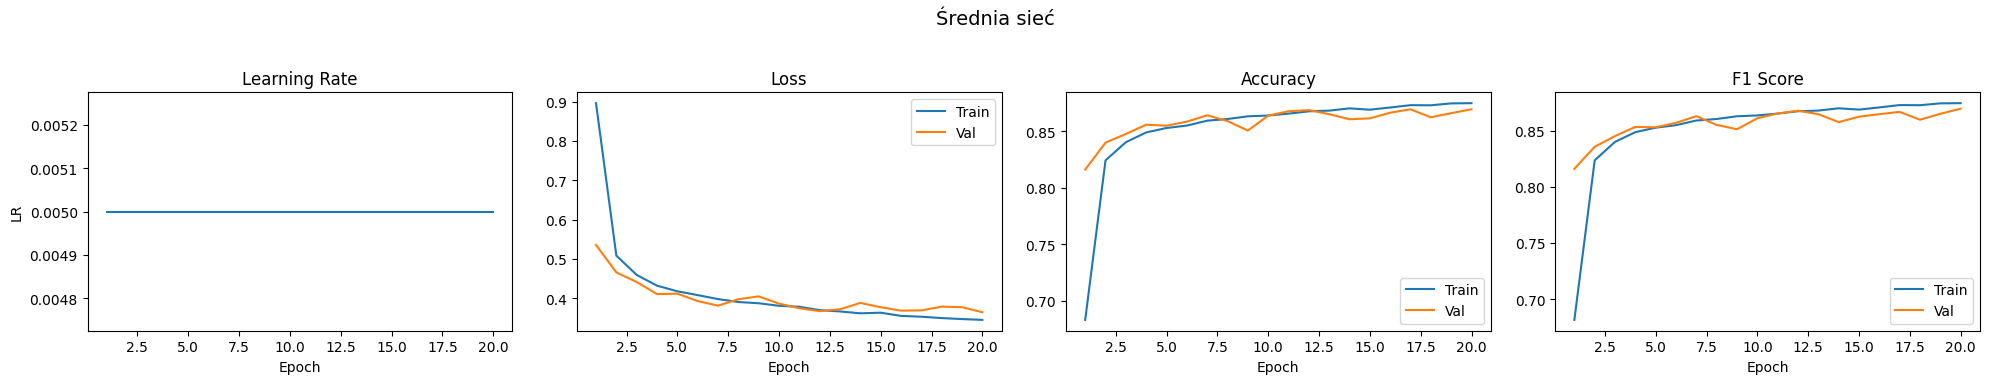

Epoch [1/20] | LR:0.005000 | Train L:0.9386 A:0.6678 F1:0.6643 | Val L:0.5513 A:0.8008 F1:0.7912
Epoch [2/20] | LR:0.005000 | Train L:0.5048 A:0.8234 F1:0.8227 | Val L:0.5109 A:0.8142 F1:0.8086
Epoch [3/20] | LR:0.005000 | Train L:0.4462 A:0.8446 F1:0.8441 | Val L:0.4420 A:0.8451 F1:0.8390
Epoch [4/20] | LR:0.005000 | Train L:0.4111 A:0.8546 F1:0.8541 | Val L:0.3898 A:0.8653 F1:0.8643
Epoch [5/20] | LR:0.005000 | Train L:0.3772 A:0.8663 F1:0.8661 | Val L:0.3661 A:0.8692 F1:0.8675
Epoch [6/20] | LR:0.005000 | Train L:0.3602 A:0.8722 F1:0.8718 | Val L:0.3706 A:0.8671 F1:0.8602
Epoch [7/20] | LR:0.005000 | Train L:0.3455 A:0.8761 F1:0.8758 | Val L:0.3272 A:0.8862 F1:0.8853
Epoch [8/20] | LR:0.005000 | Train L:0.3347 A:0.8791 F1:0.8787 | Val L:0.3470 A:0.8793 F1:0.8778
Epoch [9/20] | LR:0.005000 | Train L:0.3292 A:0.8818 F1:0.8814 | Val L:0.3553 A:0.8699 F1:0.8673
Epoch [10/20] | LR:0.005000 | Train L:0.3142 A:0.8857 F1:0.8855 | Val L:0.3426 A:0.8808 F1:0.8783
Epoch [11/20] | LR:0.005000 |

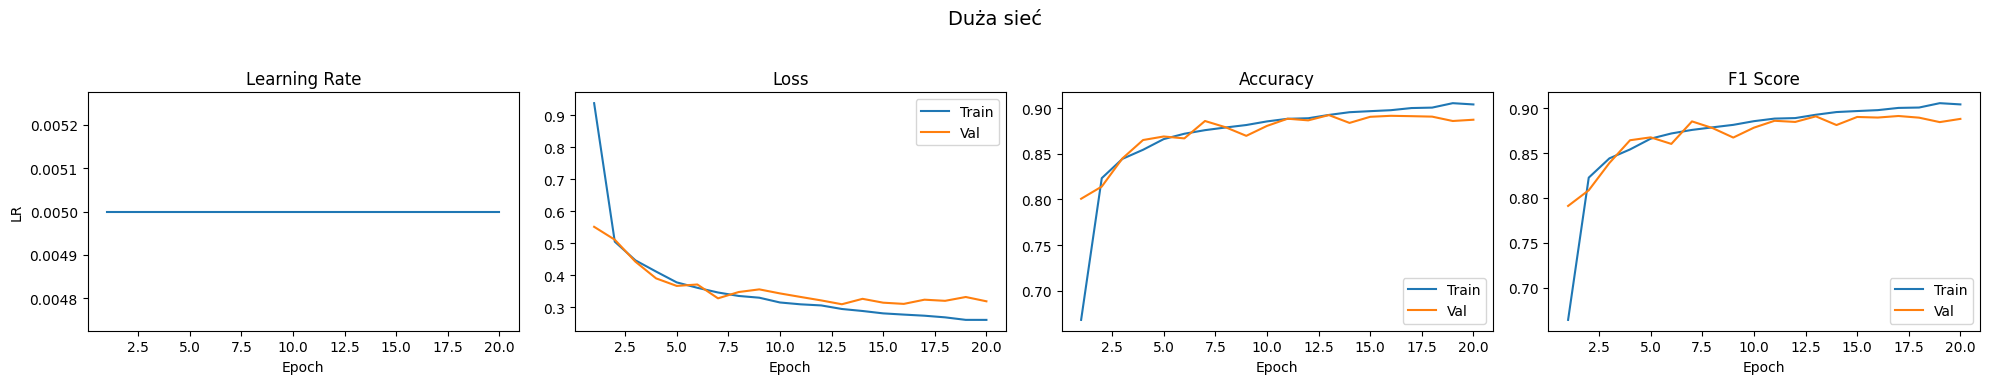

2. Early stopping
Epoch [1/20] | LR:0.005000 | Train L:0.8960 A:0.6832 F1:0.6814 | Val L:0.5356 A:0.8161 F1:0.8161
Epoch [2/20] | LR:0.005000 | Train L:0.5086 A:0.8243 F1:0.8236 | Val L:0.4658 A:0.8399 F1:0.8357
Epoch [3/20] | LR:0.005000 | Train L:0.4595 A:0.8403 F1:0.8401 | Val L:0.4416 A:0.8476 F1:0.8452
Epoch [4/20] | LR:0.005000 | Train L:0.4322 A:0.8489 F1:0.8487 | Val L:0.4108 A:0.8558 F1:0.8534
Epoch [5/20] | LR:0.005000 | Train L:0.4180 A:0.8529 F1:0.8527 | Val L:0.4119 A:0.8549 F1:0.8530
Epoch [6/20] | LR:0.005000 | Train L:0.4082 A:0.8550 F1:0.8550 | Val L:0.3931 A:0.8585 F1:0.8570
Epoch [7/20] | LR:0.005000 | Train L:0.3982 A:0.8593 F1:0.8591 | Val L:0.3815 A:0.8641 F1:0.8630
Epoch [8/20] | LR:0.005000 | Train L:0.3907 A:0.8608 F1:0.8604 | Val L:0.3976 A:0.8590 F1:0.8551
Epoch [9/20] | LR:0.005000 | Train L:0.3876 A:0.8632 F1:0.8629 | Val L:0.4051 A:0.8506 F1:0.8513
Epoch [10/20] | LR:0.005000 | Train L:0.3811 A:0.8639 F1:0.8636 | Val L:0.3866 A:0.8638 F1:0.8611
Epoch [11/2

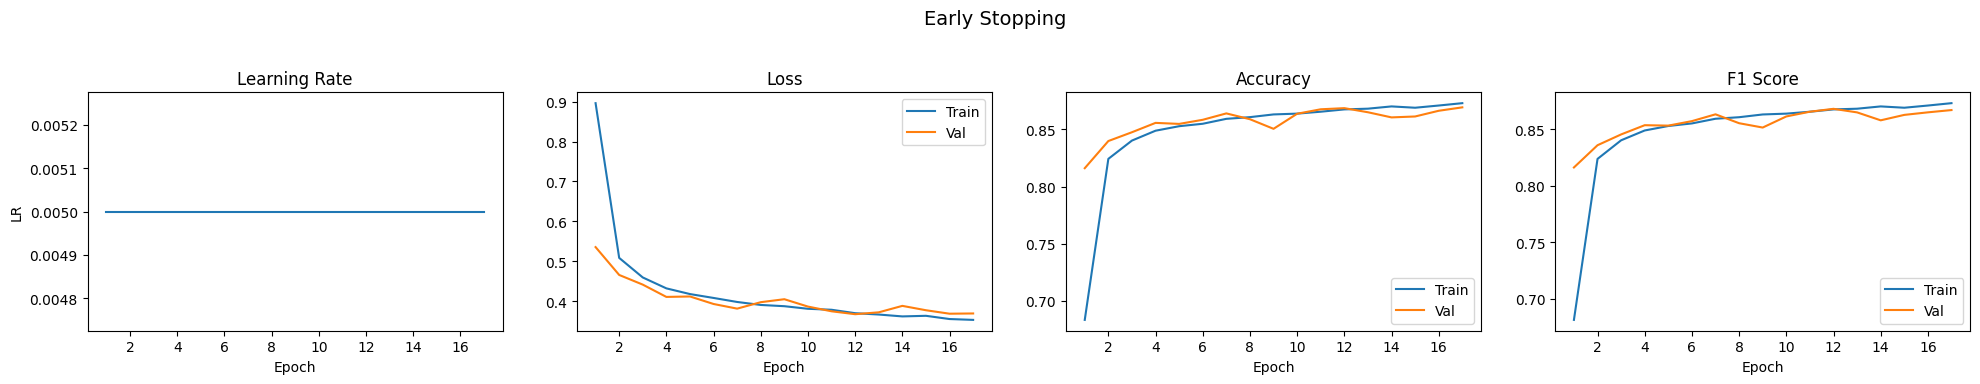

3. Regularization
Epoch [1/20] | LR:0.005000 | Train L:0.9152 A:0.6776 F1:0.6750 | Val L:0.5451 A:0.8125 F1:0.8120
Epoch [2/20] | LR:0.005000 | Train L:0.5221 A:0.8226 F1:0.8220 | Val L:0.4661 A:0.8358 F1:0.8313
Epoch [3/20] | LR:0.005000 | Train L:0.4725 A:0.8402 F1:0.8398 | Val L:0.4365 A:0.8472 F1:0.8434
Epoch [4/20] | LR:0.005000 | Train L:0.4481 A:0.8479 F1:0.8478 | Val L:0.4058 A:0.8543 F1:0.8512
Epoch [5/20] | LR:0.005000 | Train L:0.4290 A:0.8540 F1:0.8540 | Val L:0.3967 A:0.8569 F1:0.8549
Epoch [6/20] | LR:0.005000 | Train L:0.4210 A:0.8568 F1:0.8568 | Val L:0.3840 A:0.8641 F1:0.8621
Epoch [7/20] | LR:0.005000 | Train L:0.4111 A:0.8604 F1:0.8603 | Val L:0.3803 A:0.8646 F1:0.8639
Epoch [8/20] | LR:0.005000 | Train L:0.4063 A:0.8613 F1:0.8611 | Val L:0.3822 A:0.8615 F1:0.8589
Epoch [9/20] | LR:0.005000 | Train L:0.4028 A:0.8632 F1:0.8630 | Val L:0.3890 A:0.8580 F1:0.8561
Epoch [10/20] | LR:0.005000 | Train L:0.3957 A:0.8654 F1:0.8653 | Val L:0.3988 A:0.8544 F1:0.8509
Epoch [11/2

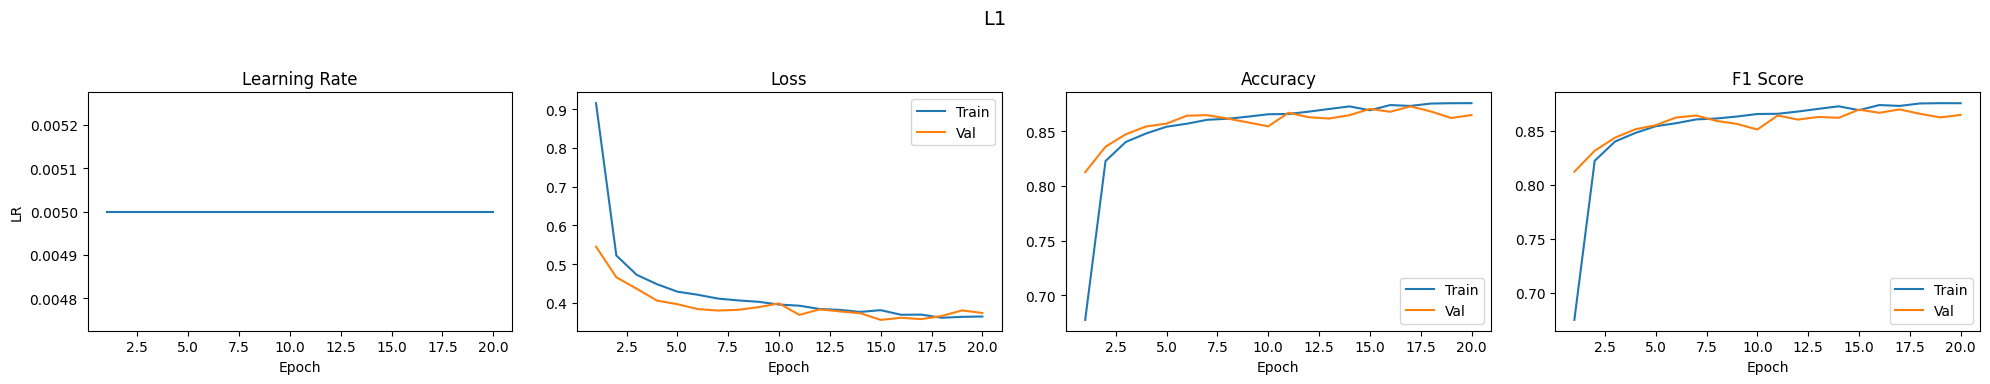

Epoch [1/20] | LR:0.005000 | Train L:0.8718 A:0.6879 F1:0.6854 | Val L:0.5527 A:0.8066 F1:0.8056
Epoch [2/20] | LR:0.005000 | Train L:0.5220 A:0.8213 F1:0.8201 | Val L:0.4973 A:0.8279 F1:0.8240
Epoch [3/20] | LR:0.005000 | Train L:0.4814 A:0.8350 F1:0.8342 | Val L:0.4466 A:0.8473 F1:0.8442
Epoch [4/20] | LR:0.005000 | Train L:0.4532 A:0.8440 F1:0.8435 | Val L:0.4150 A:0.8570 F1:0.8541
Epoch [5/20] | LR:0.005000 | Train L:0.4362 A:0.8488 F1:0.8484 | Val L:0.4173 A:0.8540 F1:0.8522
Epoch [6/20] | LR:0.005000 | Train L:0.4271 A:0.8521 F1:0.8517 | Val L:0.4219 A:0.8534 F1:0.8502
Epoch [7/20] | LR:0.005000 | Train L:0.4191 A:0.8547 F1:0.8542 | Val L:0.3908 A:0.8660 F1:0.8641
Epoch [8/20] | LR:0.005000 | Train L:0.4046 A:0.8583 F1:0.8578 | Val L:0.3963 A:0.8618 F1:0.8580
Epoch [9/20] | LR:0.005000 | Train L:0.4091 A:0.8574 F1:0.8568 | Val L:0.4082 A:0.8570 F1:0.8569
Epoch [10/20] | LR:0.005000 | Train L:0.3941 A:0.8622 F1:0.8617 | Val L:0.4119 A:0.8595 F1:0.8562
Epoch [11/20] | LR:0.005000 |

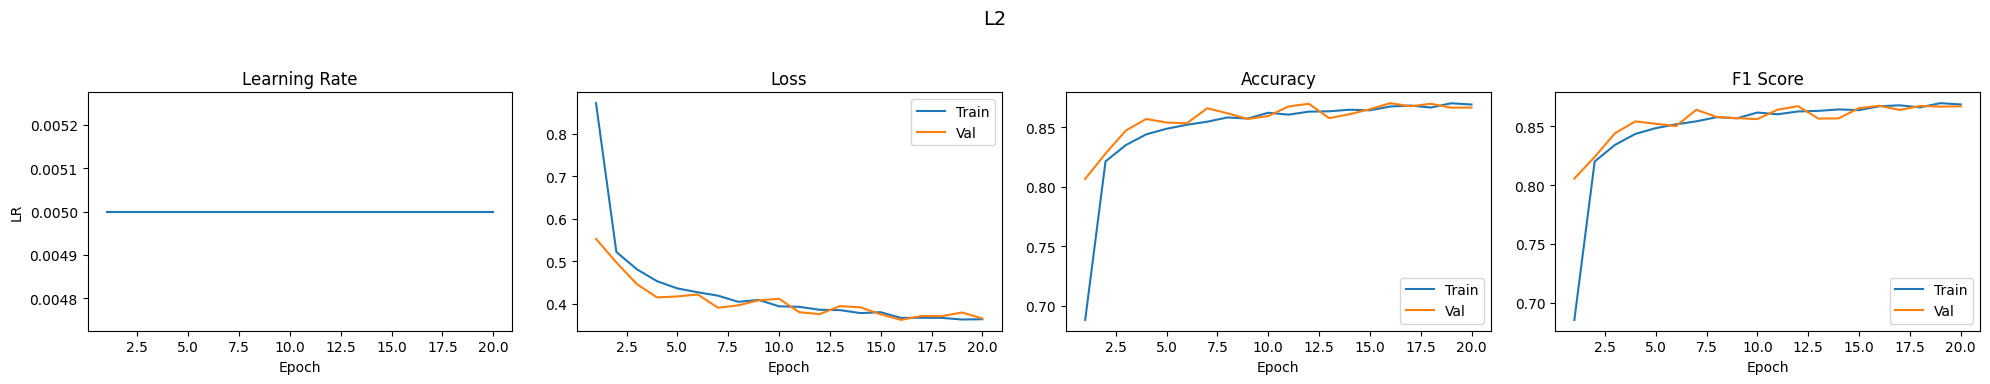

Epoch [1/20] | LR:0.005000 | Train L:0.9222 A:0.6758 F1:0.6731 | Val L:0.5749 A:0.8013 F1:0.8011
Epoch [2/20] | LR:0.005000 | Train L:0.5577 A:0.8127 F1:0.8122 | Val L:0.5057 A:0.8287 F1:0.8265
Epoch [3/20] | LR:0.005000 | Train L:0.5089 A:0.8293 F1:0.8291 | Val L:0.4554 A:0.8460 F1:0.8440
Epoch [4/20] | LR:0.005000 | Train L:0.4854 A:0.8377 F1:0.8377 | Val L:0.4417 A:0.8478 F1:0.8474
Epoch [5/20] | LR:0.005000 | Train L:0.4700 A:0.8427 F1:0.8428 | Val L:0.4304 A:0.8486 F1:0.8470
Epoch [6/20] | LR:0.005000 | Train L:0.4565 A:0.8467 F1:0.8468 | Val L:0.4196 A:0.8569 F1:0.8564
Epoch [7/20] | LR:0.005000 | Train L:0.4434 A:0.8507 F1:0.8508 | Val L:0.4048 A:0.8598 F1:0.8588
Epoch [8/20] | LR:0.005000 | Train L:0.4386 A:0.8514 F1:0.8514 | Val L:0.4103 A:0.8591 F1:0.8568
Epoch [9/20] | LR:0.005000 | Train L:0.4276 A:0.8555 F1:0.8556 | Val L:0.4184 A:0.8512 F1:0.8490
Epoch [10/20] | LR:0.005000 | Train L:0.4177 A:0.8572 F1:0.8572 | Val L:0.3994 A:0.8576 F1:0.8558
Epoch [11/20] | LR:0.005000 |

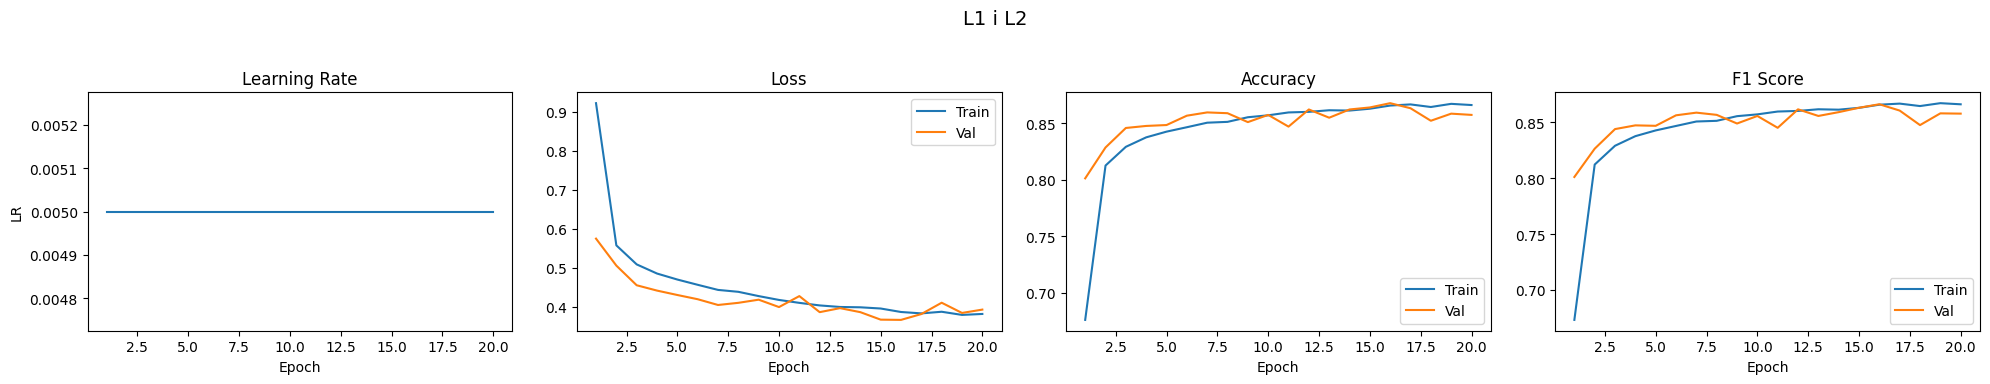

4. Dropout
Epoch [1/20] | LR:0.005000 | Train L:1.4675 A:0.4324 F1:0.4315 | Val L:0.8091 A:0.7420 F1:0.7302
Epoch [2/20] | LR:0.005000 | Train L:1.1540 A:0.5476 F1:0.5499 | Val L:0.7121 A:0.7443 F1:0.7251
Epoch [3/20] | LR:0.005000 | Train L:1.0644 A:0.5907 F1:0.5885 | Val L:0.6708 A:0.7996 F1:0.7903
Epoch [4/20] | LR:0.005000 | Train L:1.0116 A:0.6266 F1:0.6240 | Val L:0.6261 A:0.8207 F1:0.8159
Epoch [5/20] | LR:0.005000 | Train L:0.9869 A:0.6409 F1:0.6385 | Val L:0.5948 A:0.8279 F1:0.8261
Epoch [6/20] | LR:0.005000 | Train L:0.9695 A:0.6487 F1:0.6474 | Val L:0.5631 A:0.8192 F1:0.8062
Epoch [7/20] | LR:0.005000 | Train L:0.9611 A:0.6516 F1:0.6501 | Val L:0.5790 A:0.8202 F1:0.8166
Epoch [8/20] | LR:0.005000 | Train L:0.9548 A:0.6566 F1:0.6558 | Val L:0.5553 A:0.8294 F1:0.8208
Epoch [9/20] | LR:0.005000 | Train L:0.9411 A:0.6619 F1:0.6617 | Val L:0.5668 A:0.8352 F1:0.8340
Epoch [10/20] | LR:0.005000 | Train L:0.9335 A:0.6651 F1:0.6643 | Val L:0.5550 A:0.8327 F1:0.8286
Epoch [11/20] | LR

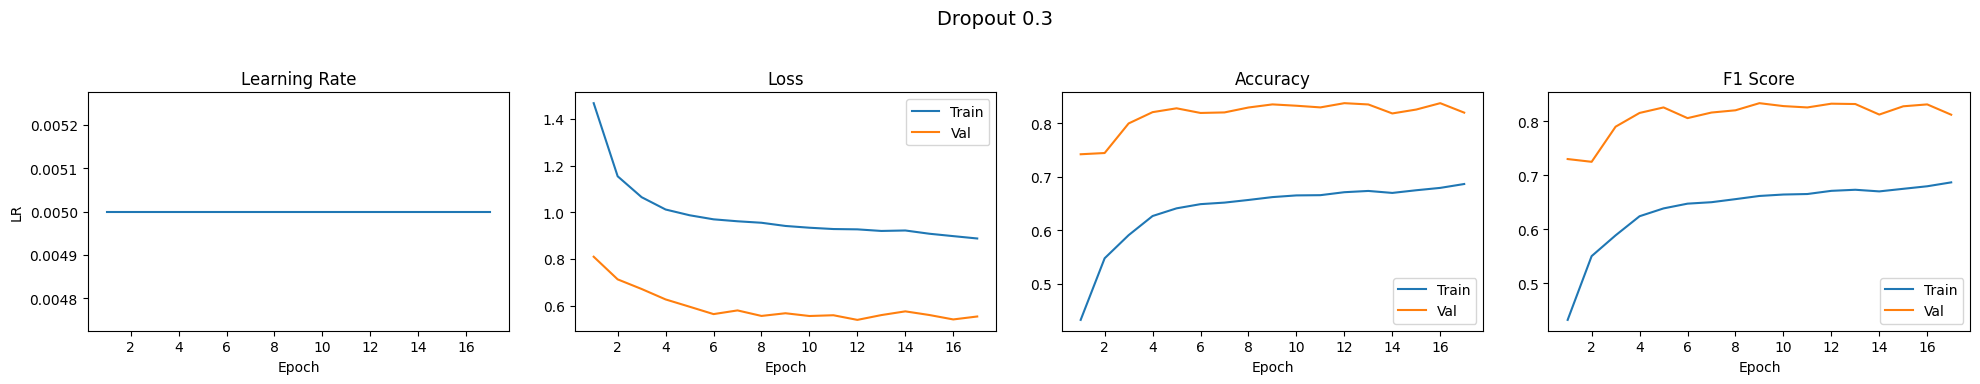

5. Batch normalization
Epoch [1/20] | LR:0.005000 | Train L:1.3842 A:0.4826 F1:0.4786 | Val L:0.7352 A:0.7989 F1:0.7921
Epoch [2/20] | LR:0.005000 | Train L:1.0817 A:0.5764 F1:0.5714 | Val L:0.6374 A:0.8054 F1:0.7929
Epoch [3/20] | LR:0.005000 | Train L:1.0207 A:0.6007 F1:0.5964 | Val L:0.6088 A:0.7935 F1:0.7853
Epoch [4/20] | LR:0.005000 | Train L:0.9949 A:0.6192 F1:0.6155 | Val L:0.5475 A:0.8252 F1:0.8215
Epoch [5/20] | LR:0.005000 | Train L:0.9779 A:0.6299 F1:0.6253 | Val L:0.5261 A:0.8368 F1:0.8326
Epoch [6/20] | LR:0.005000 | Train L:0.9659 A:0.6341 F1:0.6295 | Val L:0.5280 A:0.8296 F1:0.8179
Epoch [7/20] | LR:0.005000 | Train L:0.9602 A:0.6417 F1:0.6369 | Val L:0.5451 A:0.8303 F1:0.8244
Epoch [8/20] | LR:0.005000 | Train L:0.9585 A:0.6416 F1:0.6376 | Val L:0.5506 A:0.8264 F1:0.8111
Epoch [9/20] | LR:0.005000 | Train L:0.9444 A:0.6487 F1:0.6444 | Val L:0.5416 A:0.8237 F1:0.8146
Epoch [10/20] | LR:0.005000 | Train L:0.9445 A:0.6503 F1:0.6458 | Val L:0.5468 A:0.8303 F1:0.8219
Early 

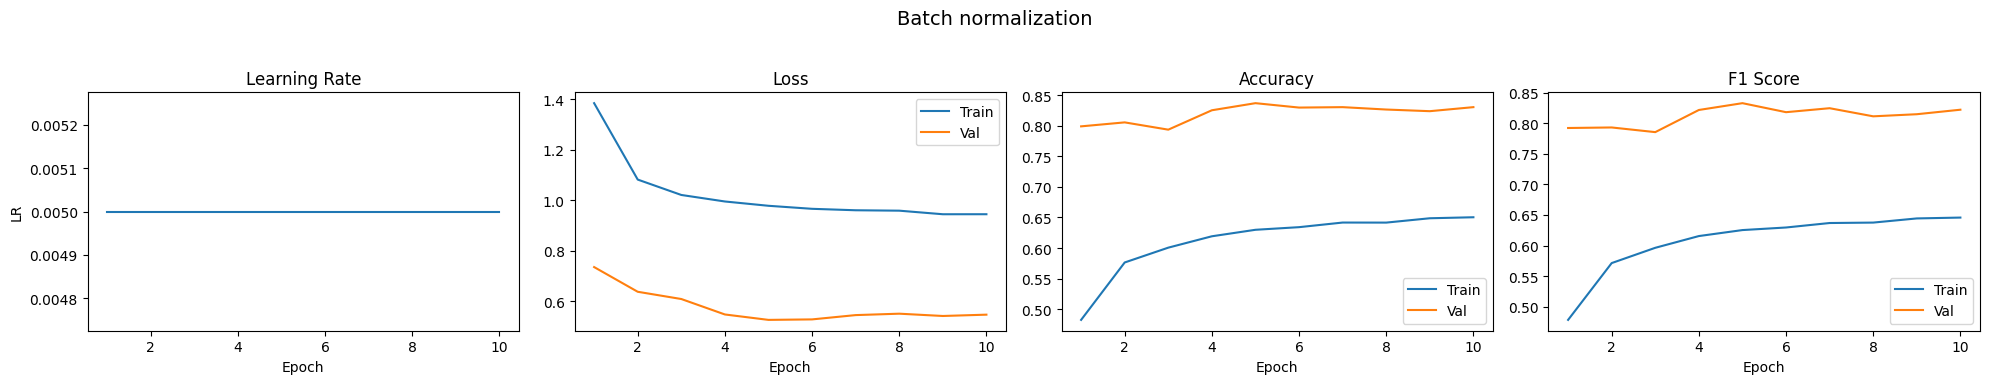

6. Learning Rate Scheduling
Epoch [1/20] | LR:0.005000 | Train L:1.3842 A:0.4826 F1:0.4786 | Val L:0.7352 A:0.7989 F1:0.7921
Epoch [2/20] | LR:0.004969 | Train L:1.0824 A:0.5764 F1:0.5712 | Val L:0.6221 A:0.8094 F1:0.7947
Epoch [3/20] | LR:0.004878 | Train L:1.0209 A:0.6005 F1:0.5958 | Val L:0.6365 A:0.7656 F1:0.7504
Epoch [4/20] | LR:0.004728 | Train L:0.9951 A:0.6168 F1:0.6133 | Val L:0.5684 A:0.8189 F1:0.8119
Epoch [5/20] | LR:0.004523 | Train L:0.9783 A:0.6263 F1:0.6229 | Val L:0.5279 A:0.8353 F1:0.8299
Epoch [6/20] | LR:0.004268 | Train L:0.9623 A:0.6324 F1:0.6311 | Val L:0.5376 A:0.8215 F1:0.8099
Epoch [7/20] | LR:0.003970 | Train L:0.9542 A:0.6420 F1:0.6393 | Val L:0.5476 A:0.8179 F1:0.8057
Epoch [8/20] | LR:0.003635 | Train L:0.9505 A:0.6417 F1:0.6391 | Val L:0.5527 A:0.8273 F1:0.8198
Epoch [9/20] | LR:0.003273 | Train L:0.9376 A:0.6470 F1:0.6434 | Val L:0.5241 A:0.8198 F1:0.8084
Epoch [10/20] | LR:0.002892 | Train L:0.9348 A:0.6476 F1:0.6436 | Val L:0.5364 A:0.8293 F1:0.8235
E

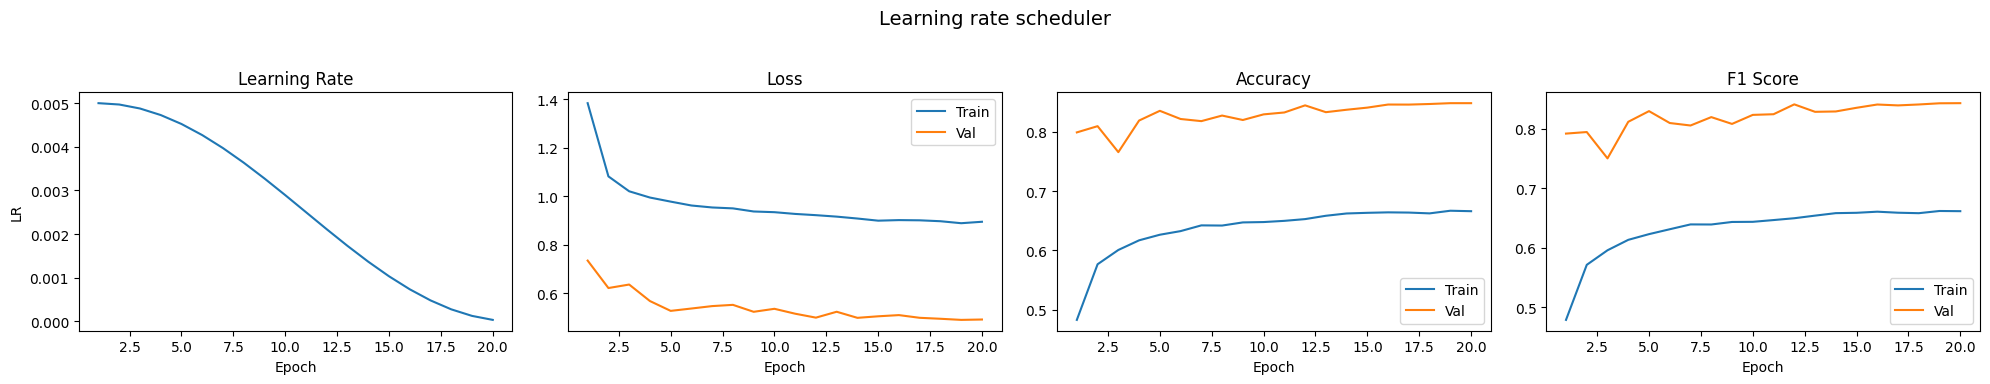

7. Optymalizator
Epoch [1/20] | LR:0.005000 | Train L:2.0246 A:0.2840 F1:0.2543 | Val L:1.8298 A:0.4480 F1:0.3801
Epoch [2/20] | LR:0.004969 | Train L:1.8541 A:0.3749 F1:0.3557 | Val L:1.6942 A:0.5989 F1:0.5530
Epoch [3/20] | LR:0.004878 | Train L:1.7501 A:0.4108 F1:0.3864 | Val L:1.5669 A:0.6402 F1:0.5862
Epoch [4/20] | LR:0.004728 | Train L:1.6730 A:0.4325 F1:0.4046 | Val L:1.4629 A:0.6534 F1:0.6000
Epoch [5/20] | LR:0.004523 | Train L:1.6062 A:0.4498 F1:0.4201 | Val L:1.3847 A:0.6733 F1:0.6219
Epoch [6/20] | LR:0.004268 | Train L:1.5551 A:0.4612 F1:0.4340 | Val L:1.3110 A:0.6837 F1:0.6355
Epoch [7/20] | LR:0.003970 | Train L:1.5153 A:0.4687 F1:0.4438 | Val L:1.2453 A:0.7070 F1:0.6623
Epoch [8/20] | LR:0.003635 | Train L:1.4799 A:0.4786 F1:0.4571 | Val L:1.2050 A:0.7174 F1:0.6754
Epoch [9/20] | LR:0.003273 | Train L:1.4502 A:0.4861 F1:0.4658 | Val L:1.1644 A:0.7277 F1:0.6911
Epoch [10/20] | LR:0.002892 | Train L:1.4302 A:0.4884 F1:0.4699 | Val L:1.1470 A:0.7278 F1:0.6928
Epoch [11/20

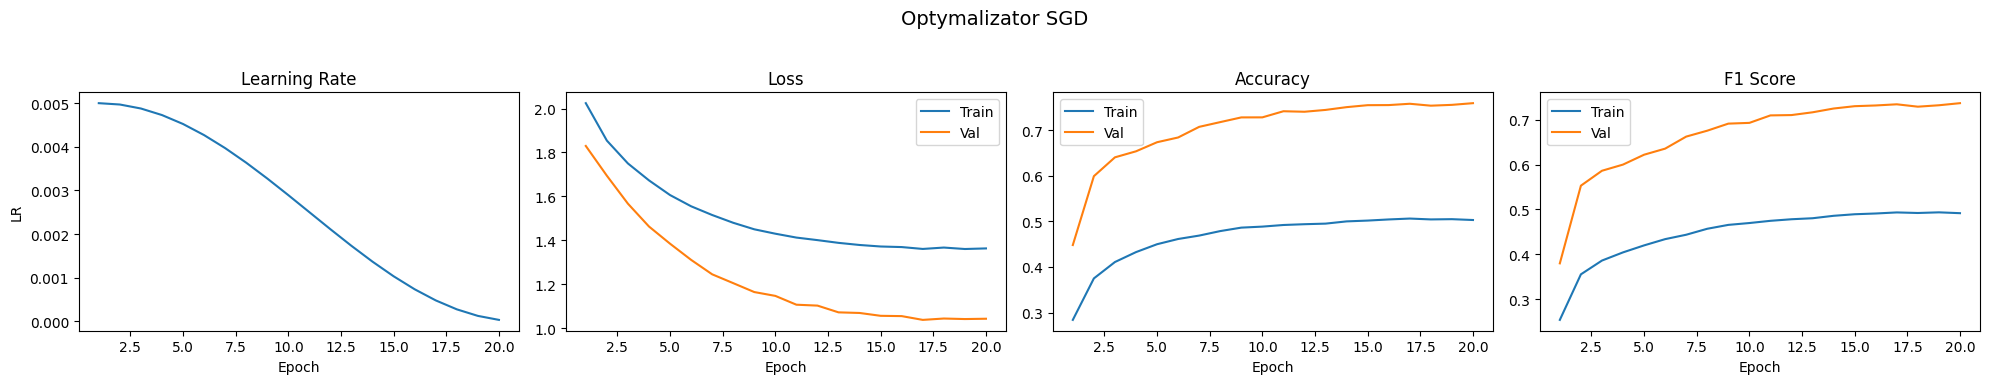

In [ ]:
input_size = 28*28
output_size = 10


sizes1  = [8]
sizes2 = [15, 8]
sizes3 = [64, 32, 16, 8]
use_batchnorm = False
lr = 0.005

print("1. Różne wymiary")
set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes1, output_size, use_batchnorm)
_, hst = train_model(model=model, lr=lr, train_loader = train_loader, val_loader = val_loader, patience=0)
plot_history(hst, "Mała sieć")

set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=0)
plot_history(hst, "Średnia sieć")

set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes3, output_size, use_batchnorm)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=0)
plot_history(hst, "Duża sieć")

print("2. Early stopping")
set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=5)
plot_history(hst, "Early Stopping")

print("3. Regularization")
set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=5, l1_lambda = 0.00001)
plot_history(hst, "L1")

set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=5, l2_lambda = 0.0001)
plot_history(hst, "L2")

set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=5, l1_lambda = 0.00001, l2_lambda = 0.0001)
plot_history(hst, "L1 i L2")

print("4. Dropout")
set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm, dropout_p=0.3)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=5, l1_lambda = 0.00001, l2_lambda = 0.0001)
plot_history(hst, "Dropout 0.3")

print("5. Batch normalization")
use_batchnorm = True
set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm, dropout_p=0.3)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=5, l1_lambda = 0.00001, l2_lambda = 0.0001)
plot_history(hst, "Batch normalization")

print("6. Learning Rate Scheduling")
set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm, dropout_p=0.3)
_, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=5, l1_lambda = 0.00001, l2_lambda = 0.0001, use_cosine_scheduler=True)
plot_history(hst, "Learning rate scheduler")

print("7. Optymalizator")
set_seed(8)
train_loader.generator.manual_seed(seed)
model = ParameterizedMLP(input_size, sizes2, output_size, use_batchnorm, dropout_p=0.3)
_, hst = train_model(model=model, lr=lr, train_loader = train_loader, val_loader = val_loader, patience=5, l1_lambda = 0.00001, l2_lambda = 0.0001,optim_class=optim.SGD, use_cosine_scheduler=True)
plot_history(hst, "Optymalizator SGD")